In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import PIL
import sklearn.metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import seaborn as sns
import pandas 
from keras import models

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
  tf.config.experimental.set_memory_growth(device, True)

tf.test.is_built_with_cuda
print('Num Gpu Avaible' ,len(physical_devices))

Num Gpu Avaible 1


In [3]:
batch_size = 10
img_height = 160
img_width = 160

train_ds = tf.keras.utils.image_dataset_from_directory(
  "classification/ip102_v1.1/train",
  # validation_split=0.2,
  # subset="training",
  # seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  "classification/ip102_v1.1/val",
  # validation_split=0.2,
  # subset="validation",
  # seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "classification/ip102_v1.1/test",
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size
 )

Found 45095 files belonging to 102 classes.
Found 7508 files belonging to 102 classes.
Found 22619 files belonging to 102 classes.


In [4]:
class_names = tuple(val_ds.class_names)
print(class_names)
len(class_names)

('Adristyrannus', 'Aleurocanthus spiniferus', 'Ampelophaga', 'Aphis citricola Vander Goot', 'Apolygus lucorum', 'Bactrocera tsuneonis', 'Beet spot flies', 'Brevipoalpus lewisi McGregor', 'Ceroplastes rubens', 'Chlumetia transversa', 'Chrysomphalus aonidum', 'Cicadella viridis', 'Cicadellidae', 'Colomerus vitis', 'Dacus dorsalis(Hendel)', 'Dasineura sp', 'Deporaus marginatus Pascoe', 'Erythroneura apicalis', 'Icerya purchasi Maskell', 'Lawana imitata Melichar', 'Limacodidae', 'Locustoidea', 'Lycorma delicatula', 'Mango flat beak leafhopper', 'Miridae', 'Nipaecoccus vastalor', 'Panonchus citri McGregor', 'Papilio xuthus', 'Parlatoria zizyphus Lucus', 'Phyllocnistis citrella Stainton', 'Phyllocoptes oleiverus ashmead', 'Pieris canidia', 'Polyphagotars onemus latus', 'Potosiabre vitarsis', 'Prodenia litura', 'Pseudococcus comstocki Kuwana', 'Rhytidodera bowrinii white', 'Rice Stemfly', 'Salurnis marginella Guerr', 'Scirtothrips dorsalis Hood', 'Sternochetus frigidus', 'Tetradacus c Bactroc

102

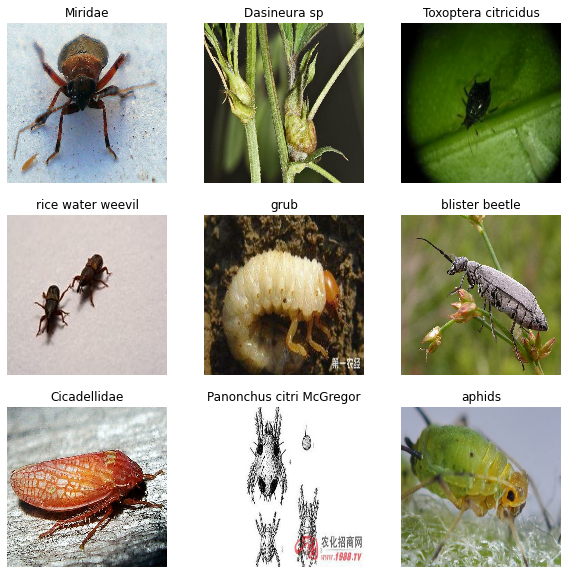

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

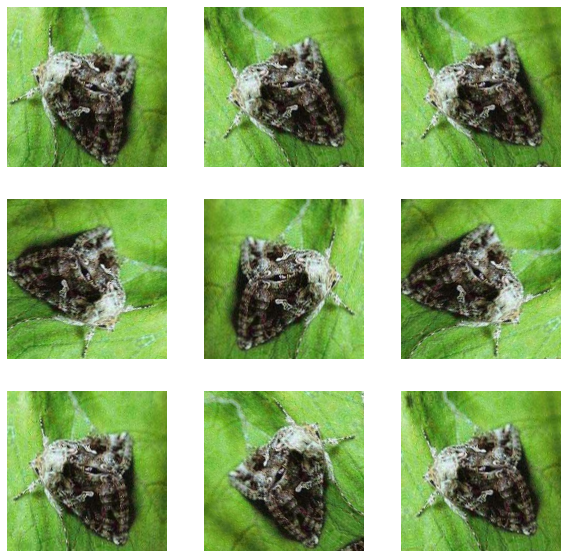

In [8]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [16]:
IMG_SHAPE = (img_height ,img_width) + (3,)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                                    include_top=False,
                                                    weights='imagenet')

In [17]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 1, 1, 1280)


In [18]:
base_model.trainable = False

In [19]:
base_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 160, 160, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 80, 80, 16)   432         rescaling_3[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 80, 80, 16)   64          Conv[0][0]                       
___________________________________________________________________________________

In [20]:
num_classes = len(class_names)

inputs = keras.Input(shape=(img_width, img_height, 3))
x = keras.applications.mobilenet_v3.preprocess_input(inputs)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 102)               130662    
Total params: 4,357,094
Trainable params: 130,662
Non-trainable params: 4,226,432
___________________________________________

In [21]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [22]:
NUM_EPOCHS = 20

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                   )

Epoch 1/20
4510/4510 [==============================] - 93s 20ms/step - loss: 2.4945 - accuracy: 0.4144 - val_loss: 2.0625 - val_accuracy: 0.4923
Epoch 2/20
4510/4510 [==============================] - 197s 44ms/step - loss: 2.0579 - accuracy: 0.4908 - val_loss: 2.0296 - val_accuracy: 0.5112
Epoch 3/20
4510/4510 [==============================] - 175s 39ms/step - loss: 1.9756 - accuracy: 0.5089 - val_loss: 2.0488 - val_accuracy: 0.5135
Epoch 4/20
4510/4510 [==============================] - 144s 32ms/step - loss: 1.9306 - accuracy: 0.5186 - val_loss: 2.0647 - val_accuracy: 0.5190
Epoch 5/20
4510/4510 [==============================] - 244s 54ms/step - loss: 1.9013 - accuracy: 0.5234 - val_loss: 2.0773 - val_accuracy: 0.5222
Epoch 6/20
4510/4510 [==============================] - 178s 40ms/step - loss: 1.8820 - accuracy: 0.5296 - val_loss: 2.0918 - val_accuracy: 0.5228
Epoch 7/20
4510/4510 [==============================] - 228s 51ms/step - loss: 1.8823 - accuracy: 0.5295 - val_loss: 2.

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate / 10),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

In [ ]:
fine_tune_epochs = 60
total_epochs =  NUM_EPOCHS  + fine_tune_epochs


history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([NUM_EPOCHS-1,NUM_EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3])
plt.plot([NUM_EPOCHS-1,NUM_EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  predict_x=model.predict(x) 
  classes_x=np.argmax(predict_x,axis=1) 
  predictions = np.concatenate([predictions, classes_x])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])


tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

In [ ]:
cf_matrix = confusion_matrix(labels, predictions, normalize='true')
plt.figure(figsize = (40,40))
sns.heatmap(cf_matrix,
            annot=True,
            xticklabels = sorted(set(class_names)),
            yticklabels = sorted(set(class_names)),
            )
plt.xlabel("Predicted Classes",fontsize=15)
plt.ylabel("True Classes",fontsize=15)
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(labels, predictions,target_names=class_names))


In [ ]:
x, y = next(iter(test_ds))
image = x[0, :, :, :]
true_index = np.argmax(y)
plt.imshow(image.numpy().astype('uint8'))
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])


In [ ]:
tf.keras.models.save_model(model , 'model.pbtxt')
converter = tf.lite.TFLiteConverter.from_keras_model(model= model)

model_tflite = converter.convert()


open('modelMobilenetV3_2.tflite', 'wb').write(model_tflite)